In [1]:
import fsps
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
from scipy import interpolate, interp
from collections import OrderedDict
import GetOut
import mpmath
import scipy.integrate as integrate


matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


In [2]:
sp = fsps.StellarPopulation(compute_vega_mags=False,zcontinuous=1,sfh=3,
                            logzsol=0.0,dust_type=2,dust1=0.0,dust2=0.2,zred=3.0,add_igm_absorption=True)

ages = np.linspace(0,1.0,10) # in Gyr
sfr_ages = np.ones(len(ages))*50.0 # 50.0 Msol/age bin ... setting the constant sfr = 50 Msun/year

sp.set_tabular_sfh(ages, sfr_ages)

# Set a tabular SFH for use with the sfh=3 option. See the FSPS documentation for 
# information about tabular SFHs. This SFH will be piecewise linearly interpolated.

# Parameters:	
# age – Age in Gyr. ndarray of shape (ntab,)
# sfr – The SFR at each age, in Msun/yr. Must be an ndarray same length as age.
# Z – (optional) The metallicity at each age. Currently this is ignored, and the value of zmet
#   or logzsol is used for all ages. Thus setting this parameter will result in a NotImplementedError.


h = 6.6260755e-27 #erg * s
c = 2.99792458e10 #cm/s

In [3]:
age = 0.0016 #Gyr
print(age*10**9)
z = 3 #redshift #### For now just testing with optical filters

fsps_filters = []
fsps_filters.append(fsps.get_filter('wfc_acs_f435w'))
fsps_filters.append(fsps.get_filter('wfpc2_f606w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f775w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f850lp'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f105w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f125w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f160w'))
fsps_filters.append(fsps.get_filter('jwst_f200w'))
fsps_filters.append(fsps.get_filter('jwst_f277w'))
fsps_filters.append(fsps.get_filter('jwst_f356w'))
fsps_filters.append(fsps.get_filter('jwst_f444w'))

wave, spec = sp.get_spectrum(tage=age, peraa=True)

1600000.0


In [4]:
## Compute luminosity distance
omega_M = 0.27
omega_lambda = 0.73
h_0 = (72.0/3.086e+19) # per sec
hubble_d = (c/h_0) # in cm

def recip_E(z):
    return 1.0/np.sqrt(omega_M*(1+z)**3 + omega_lambda)

factor = integrate.quad(recip_E, 0, 3.0)
co_moving_dist = (factor[0] * hubble_d)
lum_dist = (1.0 + z)*co_moving_dist
print("D_L: %s [cm]" % lum_dist)

D_L: 7.86580192794533e+28 [cm]


In [5]:
# via Ned Wright's cosmology calculator: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# z=3 => 25924.2 Mpc => 25924.2e+6 pc => ~ 8e+28 cm
erg_per_L_sol = 3.828e+33 # erg * s^-1
flux_factor = erg_per_L_sol/(4*np.pi*lum_dist**2)

# Window the spectra
indices = np.where((wave >= 0) & (wave <= 60000))[0]
useWave, useSpec = wave[indices], spec[indices]

fluxSpec = useSpec * flux_factor
cgsSpec = useSpec * erg_per_L_sol

colors = ["purple","blue","cyan","green", "red", "brown", "black", "red", "green", "cyan", "blue"]

In [6]:
#integrate bluewards of 912nm (Lyman break)
#eg/ integrate cgsSpec/(h*c/lambda) from 0 to 912\AA
intInds = np.where(useWave<912)[0]

#cgsSpec in [erg * s^-1 * \AA^-1] so integrating cgsSpec/[erg * s * (AA/s)/ AA] 
#over wavelength gives [photons*s^-1] as desired

#the Lyman photon rate 
#NOTE: c in cm/s here, so need the 10^8 to get it in AA/s
lyPhotonRate = np.trapz(cgsSpec[intInds]*useWave[intInds]/float(h*c*10**8),x=useWave[intInds])
print('Lyman photon rate:',lyPhotonRate)

Lyman photon rate: 5.082980646186114e+52


In [7]:
#Generate the spectrum derived from parts 2-5 of the project
#THIS STEP IS VERY SLOW! ONLY RERUN WHEN NECESSARY (~6 minutes on Kevin's mac)

n=10 #principal quantum number to sum up to
Z=1 #ion charge
T=10000 #temp in Kelvin
n_i=10**4 #ion number density [1/cm^3]
n_e=10**2 #electron number density [1/cm^3]
f_esc=0. #escape fraction
N_LyC=lyPhotonRate
waves=np.linspace(0.08,2.4,num=1000)

otherWave,otherSpec = GetOut.get_spectrum(n, Z, T, n_i, n_e, f_esc, N_LyC, waves) #in [erg * s^-1 * \Hz^-1]
otherWave *= 10**4 #to put in \AA


[4.30172802e+39 5.42900265e+39 7.23887687e+39 ... 3.93762468e+37
 3.93598463e+37 3.93434458e+37]
[mpf('2.0686932484261713e+39') mpf('3.2390336352630165e+39')
 mpf('4.9401882787870899e+39') ... mpf('6.7338151300186937e+35')
 mpf('6.7245605408355275e+35') mpf('6.7153249637969904e+35')]


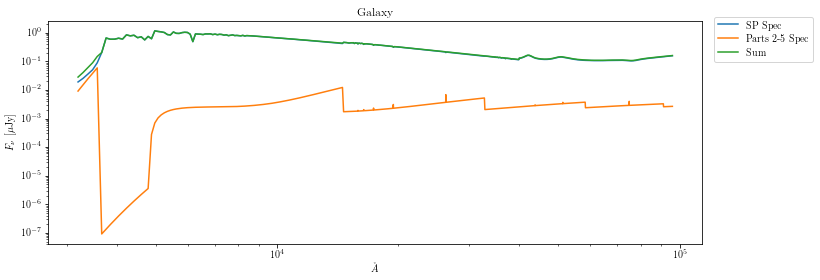

In [8]:
#NOTE: c in cm/s here, so need the 10^8 to get it in AA/s
otherSpecLam = otherSpec*(c*10**8)/otherWave**2 #otherSpec to match cgsSpec in [erg * s^-1 * \AA^-1] units

specFunc = interp(otherWave,useWave, cgsSpec)

print(specFunc)
print(otherSpecLam)

# Convert wavelength to z=3
z3_wave = otherWave * (z+1)

# Sum z=0 spectra then dim from redshift
fullSpec = (specFunc + otherSpecLam) / (4*np.pi*lum_dist**2)

#convert to Janskys
# See: https://en.wikipedia.org/wiki/AB_magnitude#Expression_in_terms_of_f%CE%BB

flux_janskySP = 3.34e+04*(z3_wave**2)*specFunc/ (4*np.pi*lum_dist**2)
flux_janskyOther = 3.34e+04*(z3_wave**2)*otherSpecLam/ (4*np.pi*lum_dist**2)
flux_janskys = flux_janskySP + flux_janskyOther
# for i,lam in enumerate(z3_wave):
#     f_v = 3.34e+04*(lam**2)*fullSpec[i]
#     flux_janskys.append(f_v)
    
# Convert jansky to microjansky
flux_microjanskys = np.asarray(flux_janskys)*1e+6

fig = plt.figure(figsize=(10, 4)) 
plt.loglog(z3_wave,flux_janskySP*1e+6,label='SP Spec')
plt.loglog(z3_wave,flux_janskyOther*1e+6,label='Parts 2-5 Spec')
plt.loglog(z3_wave,flux_microjanskys,label='Sum')
plt.title("Galaxy")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$F_{\nu}$  [$\mu$Jy]")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2)
plt.tight_layout()    
plt.show()

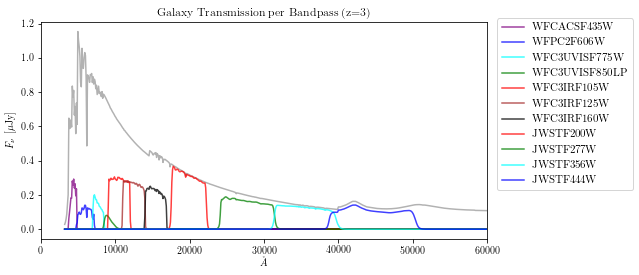

In [9]:
z3_bandpass_fluxes = OrderedDict()
filter_funcs = []
for f in fsps_filters:
    filter_func = interp(z3_wave, f.transmission[0], f.transmission[1])
    filter_funcs.append(filter_func)
    z3_bandpass_fluxes[f.name] = filter_func*flux_microjanskys
    
fig = plt.figure(figsize=(8, 4)) 

# Plot Spectra
plt.plot(z3_wave,flux_microjanskys,color='k',alpha=0.3)
plt.xlim([0,60000])
# plt.ylim([0,2.0])

# Overplot flux through each bandpass
i = 0
for name,value in z3_bandpass_fluxes.items():
    plt.plot(z3_wave,value,color=colors[i],label=name.replace('_','').upper(),alpha=0.75)    
    i+=1
    
plt.title("Galaxy Transmission per Bandpass (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$F_{\nu}$  [$\mu$Jy]")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)
plt.xlim([0,60000])
plt.show()

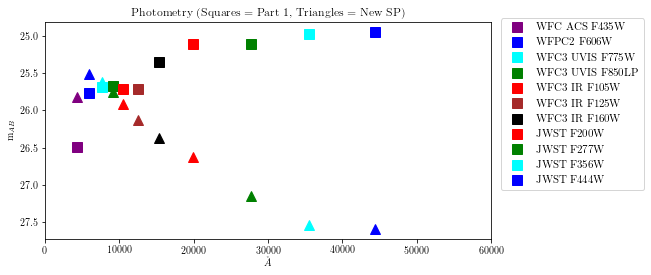

In [10]:
# Compute our own photometry

def AB(fluxes, wavelengths, transmission_spectrum):
    scaled_fluxes = np.asarray(fluxes)/(1.0 + z) # <- Not sure if this is correct, but gives the "right" answer
    top = np.trapz(scaled_fluxes * transmission_spectrum / wavelengths, x=wavelengths)
    bottom = np.trapz(3631 * transmission_spectrum / wavelengths, x=(wavelengths))
    return -2.5*mpmath.log(top/bottom, 10)

def ABmagnitude(wave,flux):
    bandpass_mag = []

    for f in filter_funcs:
        bandpass_mag.append(AB(flux,wave,f)  )
        
    return bandpass_mag


part1Data = {'filter':[],'lambda':[],'mag':[]}

f = open('part1_magData.txt','r')
data = f.readlines()
f.close()

for line in data:
    line = line.split()
    part1Data['filter'].append(line[0])
    part1Data['lambda'].append(float(line[1]))
    part1Data['mag'].append(float(line[2]))
    
fig = plt.figure(figsize=(8, 4)) 
plt.title("Photometry (Squares = Part 1, Triangles = New SP)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,60000])
plt.gca().invert_yaxis()

for i in range(len(part1Data['filter'])):
    x,y = part1Data['lambda'][i],part1Data['mag'][i]
    plt.plot(x,y,'s',markersize=10,color=colors[i], label=part1Data['filter'][i].replace('_',' '))

bpm = ABmagnitude(z3_wave,flux_janskys)
for i,m in enumerate(bpm):
    plt.plot(fsps_filters[i].lambda_eff,m,'^',markersize=10,color=colors[i])#, label=fsps_filters[i].name.replace('_',' ').upper())

plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.show()
